## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch
import numpy as np

from config import config
from RandomCutout import RandomCutout, PILImageInput

from fastai2.basics import *
from fastai2.vision.all import *

from torch.nn import MSELoss
from functools import partial

## Pretext Task: Image Inpainting

In [2]:
# Default parameters
lr=config['lr']
size=config['size']
sqrmom=config['sqrmom']
mom=config['mom']
eps=config['eps']
epochs=config['epochs']
bs=config['bs']
opt=config['opt']
sh=config['sh']
sa=config['sa']
sym=config['sym']
beta=config['beta']
act_fn=config['act_fn']
fp16=config['fp16']
pool=config['pool']
runs=config['runs']

model = config['model']

if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)
    
size = 128
bs = 64

In [3]:
# Default parameters
print("lr", lr)
print("size", size)
print("sqrmom", sqrmom)
print("mom", mom)
print("eps", eps)
print("epochs", epochs)
print("bs", bs)
print("opt", opt)
print("sh", sh)
print("sa", sa)
print("sym", sym)
print("beta", beta)
print("act_fn", act_fn)
print("fp16", fp16)
print("pool", pool)
print("runs", runs)
print("model", model)

lr 0.008
size 128
sqrmom 0.99
mom 0.9
eps 1e-06
epochs 15
bs 64
opt ranger
sh 0.0
sa 0
sym 0
beta 0.0
act_fn <class 'fastai2.layers.Mish'>
fp16 0
pool <function MaxPool at 0x7f5c13d23ef0>
runs 1
model <function xresnet34 at 0x7f5c13b32950>


In [4]:
def get_dbunch(size, bs):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5), RandomCutout]
    batch_tfms=[RandomErasing(p=0.9, max_count=3, sh=sh), Normalize] if sh else None
    
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, 
                       get_y=lambda o: o,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)

    workers = min(8, num_cpus())
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [5]:
dbunch = get_dbunch(size, bs)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

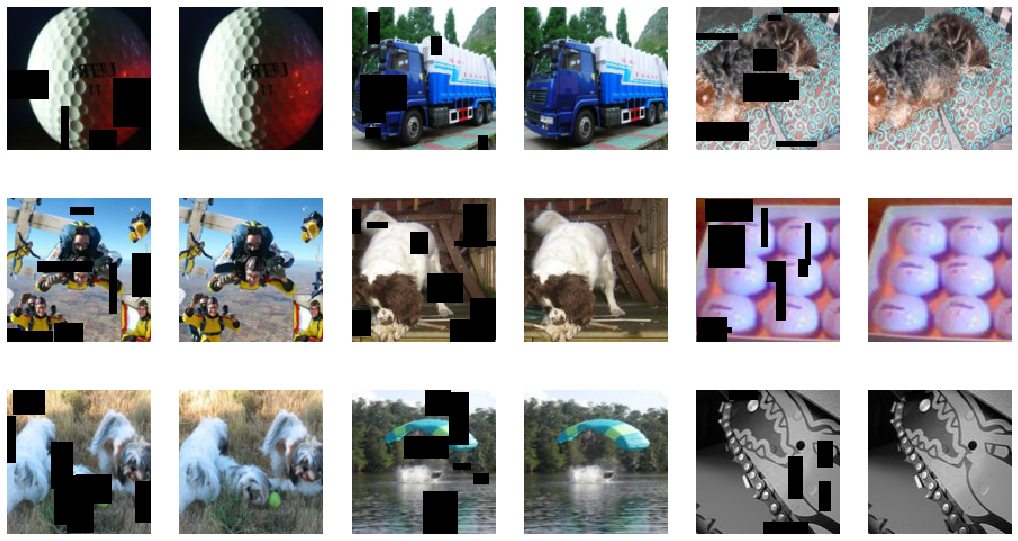

In [6]:
dbunch.show_batch()

In [7]:
learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())
if fp16: learn = learn.to_fp16()
cbs = []
learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

epoch,train_loss,valid_loss,time
0,0.185509,0.073508,01:39
1,0.010328,0.007773,01:35
2,0.006227,0.006292,01:33
3,0.005791,0.007775,01:33
4,0.005604,0.004899,01:33
5,0.005420,0.004108,01:33
6,0.005164,0.004946,01:33
7,0.005085,0.004329,01:33
8,0.004942,0.004342,01:33
9,0.004851,0.005483,01:33


In [8]:
# I'm not using fastai2's .export() because I only want to save 
# the model's parameters. 
torch.save(learn.model[0].state_dict(), 'imagewang_inpainting_15_epochs.pth')

## Downstream Task: Image Classification

In [9]:
def get_dbunch(size, bs):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) 
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    
    workers = min(8, num_cpus())
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [10]:
dbunch = get_dbunch(size, bs)

### 5 Epochs

In [11]:
epochs = 5
runs = 5

In [12]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if fp16: learn = learn.to_fp16()
        cbs = []
            
        # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs.pth')
        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        #learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.632257,4.012579,0.000255,0.203869,00:18
1,1.461105,3.727855,0.024943,0.357343,00:18
2,1.340946,3.112820,0.108425,0.516925,00:18
3,1.264968,2.890996,0.171036,0.619242,00:18
4,1.114766,2.321329,0.342835,0.798931,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.644696,3.440458,0.022398,0.416391,00:18
1,1.463929,2.775435,0.164673,0.663782,00:18
2,1.351938,3.124126,0.123441,0.516162,00:18
3,1.284185,2.734436,0.191906,0.635531,00:18
4,1.102434,2.300260,0.340036,0.807839,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.636641,3.178429,0.075337,0.578519,00:18
1,1.452969,2.954051,0.114278,0.592517,00:18
2,1.332410,3.518676,0.038687,0.388394,00:18
3,1.286807,3.830720,0.019598,0.312293,00:18
4,1.108265,2.230202,0.356070,0.830746,00:18


Run: 3


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.633419,3.226247,0.063629,0.437007,00:18
1,1.468233,2.914852,0.113769,0.551794,00:18
2,1.365376,3.099100,0.085009,0.628404,00:18
3,1.265903,2.914672,0.167727,0.581318,00:18
4,1.094176,2.302370,0.328328,0.812675,00:18


Run: 4


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.647834,3.094790,0.081955,0.472639,00:18
1,1.468106,2.916008,0.125732,0.538050,00:18
2,1.384699,3.056065,0.085009,0.518962,00:18
3,1.265367,3.207771,0.104607,0.582591,00:18
4,1.087254,2.280716,0.343853,0.819547,00:18


- Run 1: 0.342835
- Run 2: 0.340036
- Run 3: 0.356070
- Run 4: 0.328328
- Run 5: 0.343853

Average: **34.22%**

### 20 Epochs

In [13]:
epochs = 20
runs = 3

In [14]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if fp16: learn = learn.to_fp16()
        cbs = []
            
        # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs.pth')
        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.641878,3.339586,0.047086,0.455841,00:18
1,1.470613,2.639734,0.166455,0.689488,00:18
2,1.373354,3.177197,0.136167,0.573428,00:18
3,1.269196,2.843074,0.153729,0.629931,00:18
4,1.216318,3.063668,0.121405,0.580046,00:18
5,1.166838,2.530679,0.278697,0.734029,00:18
6,1.113851,2.210477,0.374650,0.824892,00:18
7,1.103624,2.484751,0.313566,0.750827,00:18
8,1.063595,2.387648,0.336981,0.784424,00:18
9,1.025837,2.342368,0.353525,0.766353,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.648966,3.031830,0.088318,0.476712,00:18
1,1.453990,3.388108,0.037923,0.456350,00:18
2,1.342746,3.610279,0.072283,0.363960,00:18
3,1.257606,2.835717,0.201323,0.634513,00:18
4,1.221146,2.573740,0.244082,0.756427,00:18
5,1.184052,2.251492,0.332400,0.815729,00:18
6,1.105386,2.207860,0.370832,0.834309,00:18
7,1.072581,2.503380,0.311275,0.773734,00:18
8,1.062823,2.336263,0.353525,0.793586,00:18
9,1.034636,2.412387,0.366251,0.849326,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.637217,3.459751,0.030797,0.480529,00:18
1,1.471204,3.290528,0.087554,0.477984,00:18
2,1.347736,2.748183,0.178417,0.688470,00:18
3,1.283246,3.023927,0.119114,0.634004,00:18
4,1.209596,2.912802,0.171036,0.642657,00:18
5,1.159842,2.358495,0.315093,0.802240,00:18
6,1.147684,2.340371,0.342072,0.801476,00:18
7,1.078789,2.778432,0.244337,0.637567,00:18
8,1.051629,2.504858,0.316620,0.756681,00:18
9,1.045536,2.632750,0.255790,0.707559,00:18


- Run 1: 0.580300
- Run 2: 0.578264
- Run 3: 0.578010

Average: **57.89%**

## 80 epochs

In [15]:
epochs = 80
runs = 1

In [16]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

        if fp16: learn = learn.to_fp16()
        cbs = []
            
        # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs.pth')
        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.646028,3.460445,0.063120,0.392975,00:18
1,1.464601,3.578434,0.042250,0.355816,00:18
2,1.353584,3.340045,0.044541,0.576483,00:18
3,1.269724,3.034379,0.139730,0.643930,00:18
4,1.199094,3.395415,0.047086,0.522525,00:18
5,1.145376,2.396597,0.301094,0.800713,00:18
6,1.132577,2.299055,0.332146,0.794604,00:18
7,1.092598,2.500705,0.308730,0.807585,00:18
8,1.051301,3.330009,0.105879,0.545940,00:18
9,1.037524,2.725702,0.258590,0.698651,00:18


Accuracy: **60.17%**

### 200 epochs

In [17]:
epochs = 200
runs = 1

In [18]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if fp16: learn = learn.to_fp16()
        cbs = []
            
        # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs.pth')
        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.663981,3.168252,0.069229,0.442861,00:18
1,1.477957,2.953303,0.113769,0.591499,00:18
2,1.344841,3.044464,0.116315,0.602952,00:18
3,1.260590,3.131198,0.124205,0.532960,00:18
4,1.207952,2.306458,0.319420,0.799186,00:18
5,1.154876,2.258248,0.333927,0.824892,00:18
6,1.138385,2.392692,0.305421,0.787987,00:18
7,1.082926,2.207793,0.395266,0.802749,00:18
8,1.045686,2.526431,0.305421,0.735302,00:18
9,1.029894,2.741468,0.271061,0.702978,00:18


Accuracy: **59.00%**